In [1]:
from collections import OrderedDict
from itertools import product

import seaborn as sns
import pandas as pd
import numpy as np

from auxiliary import get_propensity_scores_matching_demonstration_4
from auxiliary import get_sample_matching_demonstration_2
from auxiliary import get_sample_matching_demonstration_3
from auxiliary import get_sample_matching_demonstration_4
from auxiliary import get_sparsity_pattern_by_treatment
from auxiliary import get_sparsity_pattern_overall
from auxiliary import get_propensity_score_3
from auxiliary import plot_propensity_score
from auxiliary import get_common_support
from auxiliary import get_lalonde_data
from auxiliary import get_inv_odds
from auxiliary import plot_weights
from auxiliary import get_odds

np.random.seed(123)

# Matching estimators of causal effects

### Introduction

There exists only one back-door path $D \leftarrow S \leftrightarrow X \rightarrow Y$ and both $S$ nor $X$ are observable. Thus, we have a choice to condition on either one of them.

<img src="material/fig-conditioning-balance-adjust.png" width="300" />

* $X$, regression estimator, adjustment-for-other-causes conditioning strategy
* $S$, matching estimator, balancing conditioning strategy

**Agenda**

* matching as conditioning via stratification
* matching as weighting
* matching as data analysis algorithm

**Fundamental concepts**

* stratification of data
* weighting to achieve balance
* propensity scores

**Views on matching**

* method to form quasi-experimental contrasts by sampling comparable treatment and control cases
* nonparametric method of adjustment for treatment assignment patterns

**Simulation data**

The simulated data is inspired by real-world applications and thus rather complex. Nevertheless, the will serve as examples for several of the upcoming lectures. That is why we will invest some time initially to set up one of them in details.

### Matching as conditioning via stratification

Individuals within groups determined by $S$ are entirely indistinguishable from each other in all ways except 

* observed treatment status

* differences in potential outcomes that are independent of treatment status

More formally, we are able to assert the following **conditional independence assumptions**.

\begin{align}
E[Y^1 \mid D = 1, S] = E[Y^1 \mid D = 0, S] \\
E[Y^0 \mid D = 1, S] = E[Y^0 \mid D = 0, S]
\end{align}

implied by ...

* treatment assignment is ignorable
* selection on observables

**ATC**

\begin{align*}
E[\delta \mid D = 0, S] & = E[Y^1 - Y^0 \mid D = 0, S] \\
& = E[Y^1 \mid D = 0, S] - E[Y^0 \mid D = 0, S] \\
& = E[Y^1 \mid D = 1, S] - E[Y^0 \mid D = 0, S] \\
& = E[Y \mid D = 1, S] - E[Y \mid D = 0, S] \\
\end{align*}

**ATT**
\begin{align*}
E[\delta \mid D = 1, S] & = E[Y^1 - Y^0 \mid D = 1, S] \\
& = E[Y^1 \mid D = 1, S] - E[Y^0 \mid D = 1, S] \\
& = E[Y \mid D = 1, S] - E[Y \mid D = 0, S] \\
\end{align*}

Note that each of the two derivations above, requires only one of the two conditional independence assumptions.


Let's turn to our first simulation exercise:

<img src="material/fig-matching-demonstration-1.png" width="500" />

All the things we can learn:

* naive estimate

* average effect of treatment

* average effect of treatment on controls

* average effect of treatment on treated

**Notable features**

* The gains from treatment participation differ in each stratum and those that have the most to gain are more likely to participate. So unconditional independence between $D$ and $(Y^1, Y^2)$ does not hold.

Let's study these idealized conditions for a simulated dataset.

In [2]:
def get_sample_matching_demonstration_1(num_agents):
    """Simulate sample

    Simulates a sample based for mathcing demonstration one using the information provided
    in Table 6.1.

    Args:
        num_agents: An integer that specifies the number of individuals
            to sample.

    Returns:
        Returns a dataframe with the observables (Y, S, D) as well as
        the unobservables (Y_1, Y_0).
    """

    def get_potential_outcomes(s):
        """Get potential outcomes.

        Assigns the potential outcomes based on the observable S and
        the information in Table 6.1.

        Notes:
            The two potential outcomes are solely a function of the
            observable and are not associated with the treatment
            variable D.

        Args:
            s: an integer for the value of the stratification variable

        Returns:
            A tuple with the two potential outcomes.
        """
        if s == 1:
            y_1, y_0 = 4, 2
        elif s == 2:
            y_1, y_0 = 8, 6
        elif s == 3:
            y_1, y_0 = 14, 10
        else:
            raise AssertionError

        # We want some randomness.
        y_1 += np.random.normal()
        y_0 += np.random.normal()

        return y_1, y_0

    # Store some information about the sample variables
    # and initialize an empty dataframe.
    info = OrderedDict()
    info["Y"] = float
    info["D"] = int
    info["S"] = int
    info["Y_1"] = float
    info["Y_0"] = float

    df = pd.DataFrame(columns=info.keys())

    for i in range(num_agents):
        # Simulate from the joint distribution of the
        # observables.
        deviates = list(product(range(1, 4), range(2)))
        probs = [0.36, 0.08, 0.12, 0.12, 0.12, 0.20]
        idx = np.random.choice(range(6), p=probs)
        s, d = deviates[idx]

        # Get potential outcomes and determine observed
        # outcome.
        y_1, y_0 = get_potential_outcomes(s)
        y = d * y_1 + (1 - d) * y_0

        # Collect information
        df.loc[i] = y, d, s, y_1, y_0

    # We want to enforce suitable types for each column.
    # Unfortunately, this cannot be done at the time of
    # initialization.
    df = df.astype(info)

    return df

Let us see our simulation in action.

In [3]:
df = get_sample_matching_demonstration_1(num_agents=1000)
df[["Y", "D", "S"]].head()

,Y,D,S
0,9.254559,0,3
1,7.651437,0,2
2,13.795799,1,3
3,5.265936,1,1
4,3.856628,1,1


We are in the comfortable position to not only compute the naive estimate but also the true average treatment effect.

In [4]:
ate_naive = df.query("D == 1")["Y"].mean() - df.query("D == 0")["Y"].mean()
ate_true = df["Y_1"].sub(df["Y_0"]).mean()

f"The true ATE is {ate_true:4.2f} while its naive estimate is {ate_naive:4.2f}. Why?"

'The true ATE is 2.73 while its naive estimate is 5.96. Why?'

What to do?

In [5]:
df.groupby(["S", "D"])["Y"].mean()

S  D
1  0     2.086518
   1     4.187777
2  0     6.032950
   1     8.058900
3  0     9.902624
   1    14.136920
Name: Y, dtype: float64

Note that the observed outcomes within each stratum correspond to the average potential outcome 
within the stratum. We can compute the average treatment effect by looking at the difference within each strata.

In [6]:
rslt_outc = df.groupby(["S", "D"])["Y"].mean()
rslt_strat = df["S"].value_counts(normalize=True)

ate_est = 0.0
for s in [1, 2, 3]:
    ate_est += (rslt_outc.loc[s, 1] - rslt_outc.loc[s, 0]) * rslt_strat[s]

f"The stratified estimate for the ATE is {ate_est:4.2f}"

'The stratified estimate for the ATE is 2.80'

The ATT and ATC can be computed analogously just by applying the appropriate weights to the strata-specific effect of treatment.

More generally.

\begin{align*}
\{E_N [y_i \mid d_i = 1, s = s_i] - E_N [y_i \mid d_i = 0, s = s_i]\} \\
\xrightarrow{p} E[Y^1 - Y^0\mid S = s] = E[\delta \mid S = s].
\end{align*}
Weighted sums of these stratified estimates can then be taken such as for the unconditional ATE:
\begin{align*}
& \sum_s \{E_N[y_i \mid d_i = 1, s_i = s] - E_N[y_i \mid d_i = 0, s_i = s]\} \\
& * {\Pr}_N[s_i = s] \xrightarrow{p} E[\delta]
\end{align*}


This examples shows all of the basic principles in matching estimators that we will discuss in 
greater detail in this lecture. 

* Treatment and control subjects are matched together in the sense that they are grouped together 
into strata.

* An average difference between the outcomes of the treatment and control subjects is estimated, 
based on a weighting of the strata by common distribution.

#### Overlap conditions

Let's introduce our first complication:


<img src="material/fig-matching-demonstration-2.png" width="500" />


In [7]:
df = get_sample_matching_demonstration_2(num_agents=1000)
df[["Y", "D", "S"]].head()

,Y,D,S
0,0.495446,0,1
1,7.495097,1,2
2,7.614248,1,2
3,5.407392,0,2
4,12.524174,1,3


In [8]:
df.groupby(["S", "D"])["Y"].mean()

S  D
1  0     2.097111
2  0     6.028036
   1     8.058439
3  0     9.981168
   1    14.023508
Name: Y, dtype: float64

Can we at least learn about the treatment on the treated? What else can we do?

### Matching as weighting

As indicated by the stylized example, there are often many strata where we do not have treated and control individuals available at the same time.

$\rightarrow$ combine information from different strata with the same propensity score $p$

**Definition** The estimated propensity score is the estimated probability of taking the treatment as a function of variables that predict treatment assignment, i.e. $\Pr[D = 1 \mid S]$.

$\rightarrow$ stratifying on the propensity score itself ameliorates the sparseness problem because the propensity score can be treated as a single stratifying variable (Rosenbaum & Rubin (1983)).

In [9]:
# We create a grid for two observable characteristics that drive treatment selection and o
a_grid = np.linspace(0.01, 1.00, 100)
b_grid = np.linspace(0.01, 1.00, 100)

# We need to study some features of this function to
# to get a sense on the underyling economics.
df, counts = get_sample_matching_demonstration_3(a_grid, b_grid)
df.head()

,a,b,d,y,y_1,y_0,p
0,0.01,0.03,0,94.788634,102.807448,94.788634,0.332700
1,0.01,0.04,1,107.735609,107.735609,93.808018,0.334033
2,0.01,0.05,0,104.010898,97.937608,104.010898,0.335369
3,0.01,0.05,0,107.356485,98.919732,107.356485,0.335369
4,0.01,0.06,1,109.372171,109.372171,95.717052,0.336708


**underlying causal graphs**

<img src="material/fig-matching-demonstration-3.png" width="500" />

We will now look at different ways to construct estimates for the usual causal parameters. So, we first compute their true counterparts.

In [10]:
stat = df["y_1"].sub(df["y_0"]).mean()
print(f"ATE true:  {stat:5.3f}")

df_treated = df.query("d == 1")
df_control = df.query("d == 0")

stat = df_treated["y"].mean() - df_control["y"].mean()
print(f"ATE naive: {stat:5.3f}")

ATE true:  4.397
ATE naive: 4.846


Let's collect all effects in a dictionary for use further downstream.

In [11]:
true_effects = list()
true_effects += [df_treated["y_1"].sub(df_treated["y_0"]).mean()]
true_effects += [df_control["y_1"].sub(df_control["y_0"]).mean()]
true_effects += [(df["y_1"] - df["y_0"]).mean()]

How about the issue of sparsity on the data?

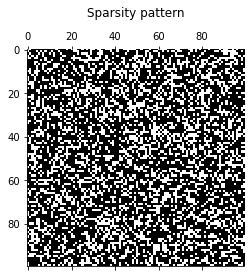

In [12]:
get_sparsity_pattern_overall(counts)

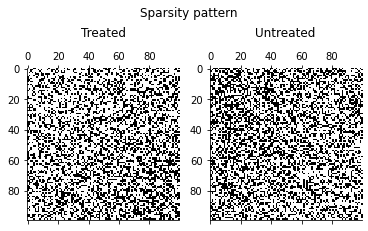

In [13]:
get_sparsity_pattern_by_treatment(counts)

How does the propensity score $P(D = 1\mid S)$ as a function of the observables $(a, b)$ look like?

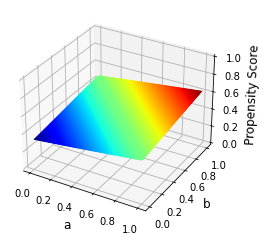

In [14]:
plot_propensity_score(a_grid, b_grid)

We still must be worried about common support.

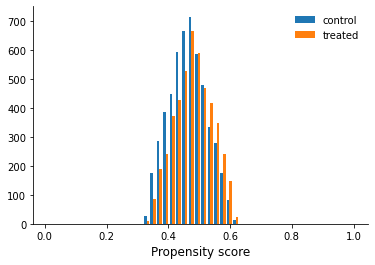

In [15]:
get_common_support(df)


\begin{align*}
\hat{\delta}_{\text{ATT, weight}} \equiv \left( \frac{1}{n^1}\sum_{i:d_i = 1} y_i\right) 
- \left(\frac{\sum_{i:d_i=0}\hat{r}_i y_i}{\sum_{i:d_i = 0} \hat{r}_i}\right)
\end{align*}

\begin{align*}
\hat{\delta}_{\text{ATC, weight}} \equiv 
\left(
\frac{\sum_{i: d_i = 1}\frac{y_i}{\hat{r}_i}}{\sum_{i: d_i = 1}\frac{1}{\hat{r}_i}}
\right)
- \left(\frac{1}{n^0} \sum_{i: d_i = 0} y_i\right) 
\end{align*}

\begin{align*}
\hat{\delta}_{\text{ATE, weight}} \equiv \left(\frac{1}{n}\sum_{i}d_i\right) \hat{\delta}_{\text{ATT, weight}} +  \left(1 - \frac{1}{n}\sum_{i}d_i\right) \hat{\delta}_{\text{ATC, weight}}
\end{align*}



**Weights** 

\begin{align*}
r_i = \frac{p_i}{1 - p_i}
\end{align*}

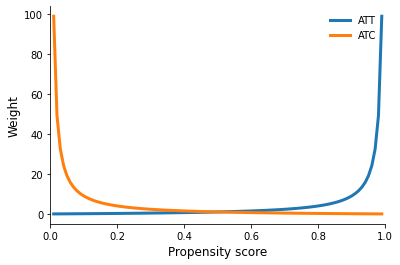

In [16]:
plot_weights()

We will now turn to some programming as it introduces you to the actual setup for the propensity score estimation and points towards the issues of potential model misspecification.

In [17]:
def get_att_weight(df, p):
    """Get weighted ATT.

    Calculates the weighted ATT basd on a provided
    dataset and the propensity score.

    Args:
        df: A dataframe with the observed data.
        p: A numpy array with the weights.

    Returns:
        A float which corresponds to the ATT.
    """
    df_int = df.copy()
    df_int["weights"] = get_odds(p)

    value, weights = df_int.query("d == 0")[["y", "weights"]].values.T
    att = df_int.query("d == 1")["y"].mean() - np.average(value, weights=weights)

    return att


def get_atc_weight(df, p):
    """Get weighted ATC.

    Calculates the weighted ATC basd on a provided
    dataset and the propensity score.

    Args:
        df: A dataframe with the observed data.
        p: A numpy array with the weights.

    Returns:
        A float which corresponds to the ATC.
    """
    df_int = df.copy()
    df_int["weights"] = get_inv_odds(p)

    value, weights = df_int.query("d == 1")[["y", "weights"]].values.T
    atc = np.average(value, weights=weights) - df.query("d == 0")["y"].mean()

    return atc


def get_ate_weight(df, p):
    """Get weighted ATE.

    Calculates the weighted ATE basd on a provided
    dataset and the propensity score.

    Args:
        df: A dataframe with the observed data.
        p: A numpy array with the weights.

    Returns:
        A float which corresponds to the ATE.
    """
    share_treated = df["d"].value_counts(normalize=True)[1]

    atc = get_atc_weight(df, p)
    att = get_att_weight(df, p)

    return share_treated * att + (1.0 - share_treated) * atc


rslt = dict()
for model in ["true", "correct", "misspecified"]:

    print("")
    print(model.capitalize())

    p = get_propensity_score_3(df, model)

    rslt[model] = list()
    rslt[model] += [get_att_weight(df, p)]
    rslt[model] += [get_atc_weight(df, p)]
    rslt[model] += [get_ate_weight(df, p)]

    print("estimated: ATT {:5.3f} ATC {:5.3f} ATE {:5.3f}".format(*rslt[model]))
    print("true:      ATT {:5.3f} ATC {:5.3f} ATE {:5.3f}".format(*true_effects))


True
estimated: ATT 4.567 ATC 4.356 ATE 4.456
true:      ATT 4.549 ATC 4.259 ATE 4.397

Correct
Optimization terminated successfully.
         Current function value: 0.683753
         Iterations 4
estimated: ATT 4.557 ATC 4.349 ATE 4.448
true:      ATT 4.549 ATC 4.259 ATE 4.397

Misspecified
Optimization terminated successfully.
         Current function value: 0.683792
         Iterations 4
estimated: ATT 4.560 ATC 4.344 ATE 4.447
true:      ATT 4.549 ATC 4.259 ATE 4.397


If the treatment assignment can be modeled perfectly, one can solve the sparseness problem that afflict finite datasets. 

**Requirements**

* perfect stratification of the propensity-score-estimating equation
    
    * capture all back-door paths
    * misspecification of propensity score equation

### Matching as data analysis algorithm

\begin{align*}
\hat{\delta}_{\text{ATT, match}} = \frac{1}{n^1} \sum_i \left[(y_i \mid d_i = 1) - \sum_j \omega_{i, j} (y_j \mid d_j =0 )\right]
\end{align*}

\begin{align*}
\hat{\delta}_{\text{ATC, match}} = \frac{1}{n^0} \sum_j \left[\sum_i \omega_{j, i} (y_i\mid d_i = 1) - (y_j \mid d_j = 0)\right]
\end{align*}

Alternative matching estimators can be represented as different procedures for deriving the weights $\omega_{i,j}$ and $\omega_{j, i}$ in the two expressions above.

**Design choices**

* How many matched cases designated for each to-be-matched target?

* How to weigh multiple matched cases if more than one is utilized for each target case?

#### Basic variants

* exact matching

    * construct counterfactual based on individuals with identical $S$


* nearest-neighbor and caliper

    * construct counterfactual based on individuals closest on a unidimensional measure (e.g. propensity score), caliper ensures reasonable maximum distance to neighbor


* interval matching

    * construct counterfactual by sorting individuals into segments based on unidimensional metric


* kernel matching

    * constructs counterfactual based on **all** individuals but weights them based on the distance

#### Benchmarking tutorial

We revisit a simulated version of the data used in Morgan (2001). He contributes to the debate over the size of the causal of effect of Catholic schooling on test scores. The dataset is provided by the textbook and also available in our online repository.

**Issues**

* What is the relative performance of alternative matching estimators?

* What is the consequence of conditioning only on a subset of the variables in the set of perfect stratification variables $S$.

In [18]:
df = get_sample_matching_demonstration_4()
df.describe()

,y,treat,asian,hispanic,black,natamer,urban,neast,ncentral,south,...,ncentralblack,southblack,twohisp,neasthisp,ncentralhisp,southhisp,yt,yc,dshock,d
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,100.459241,0.105200,0.089800,0.143300,0.096100,0.007500,0.38910,0.208100,0.264000,0.302200,...,0.018200,0.050500,0.102100,0.016000,0.014900,0.05590,105.729319,99.727395,7.105427e-18,6.001924
std,13.493304,0.306826,0.285909,0.350396,0.294743,0.086281,0.48757,0.405969,0.440821,0.459234,...,0.133681,0.218985,0.302795,0.125481,0.121159,0.22974,13.525777,13.202781,2.088954e+00,2.146356
min,50.065298,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,54.788152,50.065298,-7.765338e+00,-2.142958
25%,91.519660,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,96.848440,91.025084,-1.386373e+00,4.587783
50%,100.303288,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,105.712292,99.685598,1.763749e-02,6.010071
75%,109.459337,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,114.828609,108.607459,1.391807e+00,7.438161
max,159.426572,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,159.790235,151.442150,8.432203e+00,14.653340


Let us look at some example covariates.

In [19]:
example_covariates = ["black", "urban", "test"]
df[example_covariates].describe()

,black,urban,test
count,10000.000000,10000.00000,10000.000000
mean,0.096100,0.38910,-0.002229
std,0.294743,0.48757,0.991747
min,0.000000,0.00000,-3.862709
25%,0.000000,0.00000,-0.676463
50%,0.000000,0.00000,-0.006683
75%,0.000000,1.00000,0.660488
max,1.000000,1.00000,3.722783


<AxesSubplot:xlabel='treat', ylabel='count'>

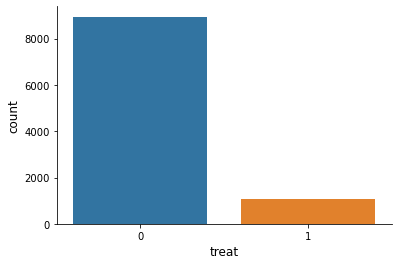

In [20]:
sns.countplot(x="treat", data=df)

<img src="material/fig-catholic-school-example.png" width="500" />

Is there any hope in identifying the $ATE$?

<img src="material/fig-matching-demonstration-four-potential-outcome.png" width="500" />

<img src="material/fig-matching-demonstration-four-propensity-score.png" width="500" />

There exists systematic treatment effect heterogeneity:

<img src="material/fig-treatment-effect-heterogeneity.png" width="500" />


Here comes the key feature that generates the dependence between $D$ and $Y$ based on an unobservable.

\begin{align*}
y_i^1 = y_i^0 + \delta^\prime_i + \delta^{\prime\prime}_i
\end{align*}

$\rightarrow$ $\delta^{\prime\prime}_i$ is a associated with one of the potential outcomes and also affects the probability to select treatment. Individuals that have the most to gain from treatment are more likely to select into treatment.

However, we can still identify the $ATT$. Why?

\begin{align*}
E[\delta \mid D = 1, S] & = E[Y^1 - Y^0 \mid D = 1, S] \\
& = E[Y^1 \mid D = 1, S] - E[Y^0 \mid D = 1, S] \\
& = E[Y^1 \mid D = 1, S] - E[Y^0 \mid D = 0, S] \\
& = E[Y \mid D = 1, S] - E[Y \mid D = 0, S] \\
\end{align*}

We establish a clear benchmark by looking at the true treatment effect.

In [21]:
stat = (df["yt"] - df["yc"])[df["treat"] == 1].mean()
print(f"The true ATT is {stat:5.3f}")

The true ATT is 6.957


How are doing with respect to common support for the propensity score?

Optimization terminated successfully.
         Current function value: 0.252643
         Iterations 8


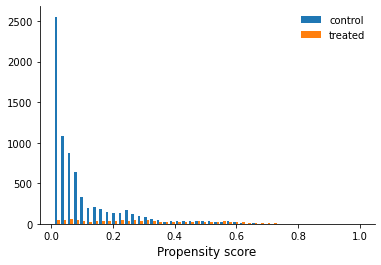

In [22]:
df = get_sample_matching_demonstration_4()
df["p"] = get_propensity_scores_matching_demonstration_4(df)
get_common_support(df, "treat")

Now we implement our own nearest neighbor matching routine.

In [23]:
def nearest_neighbor_algorithm_for_att(df):

    # We select all treated individuals
    df_control = df.query("treat == 0").reset_index()
    df_treated = df.query("treat == 1").reset_index()

    # We create a new dataframe wth the nearest neighbor.
    df_neighbour = pd.DataFrame(columns=df.columns)

    # We want to store the information about the nearest neighbor.
    idx_list = list()

    for i, (index, row) in enumerate(df_treated.iterrows()):

        df_control["distance"] = np.abs(df_control["p"] - row["p"])
        idx_ngbr = df_control["distance"].idxmin()

        df_neighbour.loc[i, :] = df_control.loc[idx_ngbr, :]

        # We want to record the index of the neighbor.
        idx_list.append(idx_ngbr)

    df_neighbour = df_neighbour.add_suffix("_ngbr")
    df_matched = pd.concat([df_treated, df_neighbour], axis=1)

    return df_matched, pd.Series(idx_list)

Let's put our algorithm to work!

In [24]:
df_matched, idx_series = nearest_neighbor_algorithm_for_att(df)

How well are we able to match individuals based on their propensity score? How does earnings compare between matched individuals?

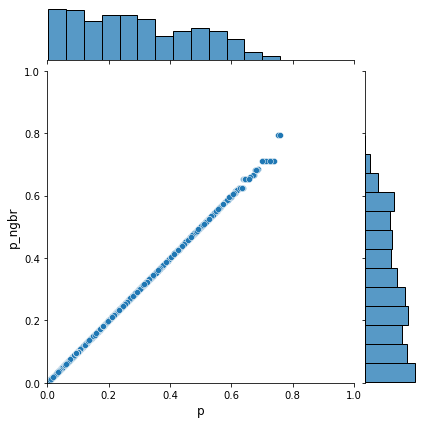

In [25]:
sns.jointplot(x="p", y="p_ngbr", data=df_matched, xlim=[0, 1], ylim=[0, 1])

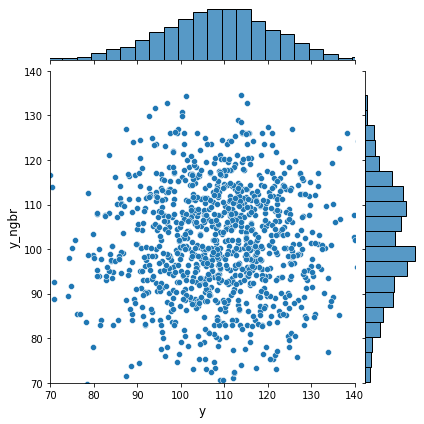

In [26]:
sns.jointplot(x="y", y="y_ngbr", data=df_matched, xlim=[70, 140], ylim=[70, 140])

After all this effort, what is our treatment effect estimate?

In [27]:
stat = (df_matched["y"] - df_matched["y_ngbr"]).mean()
print(f"Here is our estimate for the treatment effect: {stat:5.3f}")

Here is our estimate for the treatment effect: 7.236


How often do we match the same individual?

In [28]:
idx_series.value_counts()

1236    13
1701    11
1129    11
1715    10
3424     6
        ..
948      1
2998     1
2999     1
3830     1
2047     1
Length: 790, dtype: int64

How do our covariantes balance across treatment status?

In [29]:
df.groupby("treat")[example_covariates].mean().T

treat,0,1
black,0.092646,0.125475
urban,0.337953,0.824144
test,-0.039018,0.310690


We now want to revisit the balancing of covariates.

In [30]:
for col in example_covariates:
    print("\n", col)
    print(f"treated: {df_matched[col].mean():5.3f}")
    print(f"matched: {df_matched[col + '_ngbr'].mean():5.3f}")


 black
treated: 0.125
matched: 0.142

 urban
treated: 0.824
matched: 0.827

 test
treated: 0.311
matched: 0.309


Let's take a little detour and look at the balancing of observables in the Lalonde dataset.

In [31]:
df = get_lalonde_data()
df.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78,Y,Y_0,Y_1,D
0,Lalonde Sample,1,37,11,1,0,1,1,0.0,9930.0460,9930.0460,NaN,9930.0460,1
1,Lalonde Sample,1,22,9,0,1,0,1,0.0,3595.8940,3595.8940,NaN,3595.8940,1
2,Lalonde Sample,1,30,12,1,0,0,0,0.0,24909.4500,24909.4500,NaN,24909.4500,1
3,Lalonde Sample,1,27,11,1,0,0,1,0.0,7506.1460,7506.1460,NaN,7506.1460,1
4,Lalonde Sample,1,33,8,1,0,0,1,0.0,289.7899,289.7899,NaN,289.7899,1


In [32]:
example_covariates = ["black", "married", "hispanic", "re75"]
df.groupby("treat")[example_covariates].mean().T

treat,0,1
black,0.800000,0.801347
married,0.157647,0.168350
hispanic,0.112941,0.094276
re75,3026.682743,3066.098187


The covariates are balanced before any reweighting thanks to the assignment mechanisms.



Returning to our simulated example. Which matching algorihtm is the best?

**Incomplete specification**

* missing higher-order interactions in propensity score and omission of cognitive variable

<img src="material/fig-matching-demonstration-four-benchmarking.png" width="500" />


**Notes**

* The estimates for the incomplete specification are usually much larger.

* Software programs that used the same routine yield very different estimates.

### Resources

* **Heckman, J. J., Ichimura, H., Smith, J. A. and Todd, P. (1998)**. [Characterizing selection bias using experimental data](https://www.jstor.org/stable/2999630?seq=1). *Econometrica*, 66(5), 1017–98.


* **Heckman, J. J., Ichimura, H. and Todd, P. (1998)**. [Matching as an econometric evaluation estimator](https://www.jstor.org/stable/2971733?seq=1). *Review of Economic Studies*, 65(2), 261–94.


* **Heckman, J. J. and Hotz, V. J. (1989)**. [Choosing among alternative non-experimental methods for estimating the impact of social programs: The case of manpower training](https://www.jstor.org/stable/2290059?seq=1). *Journal of the American Statistical Association*, 84(408), 862–74.


* **Heckman, J. and Navarro-Lozano, S. (2004)**. [Using matching, instrumental variables, and control functions to estimate economic choice models](https://www.jstor.org/stable/3211658?seq=1). *The Review of Economics and Statistics*,  86(1), 30–57.


* **Morgan, S. (2001)**. [Counterfactuals, causal effect heterogeneity, and the catholic school effect on learning](https://www.jstor.org/stable/2673139). *Sociology of Education*, 74(4), 341–374.


* **Rosenbaum, P. R. and Rubin, D. (1983)**. [The central role of the propensity score in observational studies for causal effects](https://academic.oup.com/biomet/article/70/1/41/240879). *Biometrika*, 70(1), 41–55.


* **Smith, J. A. and Todd, P. (2005)**. [Does matching evercome Lalonde’s eritique of nonexperimental estimators?](https://www.sciencedirect.com/science/article/abs/pii/S030440760400082X). *Journal of Econometrics*, 125(1–2), 305–53.